In [1]:
import numpy as np
from tqdm.notebook import tqdm
import os
from os.path import join
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import torch as torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
batch_size = 64

In [3]:
def load_datasets():
    dataset_name = 'datasets2/888_vehicle_animal/'
    y_labeled = np.load(join(dataset_name, "y_labeled.npy"))
    X_labeled = np.load(join(dataset_name, "X_labeled.npy"))
    X_unlabeled = np.load(join(dataset_name, "X_unlabeled.npy"))
    X_val = np.load(join(dataset_name, "X_val.npy"))

    # To tensor with device
    X_labeled = torch.from_numpy(X_labeled).float()
    y_labeled = torch.from_numpy(y_labeled).float()
    X_unlabeled = torch.from_numpy(X_unlabeled).float()
    X_val = torch.from_numpy(X_val).float()

    return X_labeled, y_labeled, X_unlabeled, X_val
  
X_labeled, y_labeled, X_unlabeled, X_val = load_datasets()

In [4]:
print("Labeled ds shape: ", X_labeled.shape)
print("Unlabeled ds shape: ", X_unlabeled.shape)
print("Validation ds shape: ", X_val.shape)
print("Labels shape: ", y_labeled.shape)
print("Labeled ds labels: ", np.unique(y_labeled.cpu()))

Labeled ds shape:  torch.Size([10000, 3, 32, 64])
Unlabeled ds shape:  torch.Size([20000, 3, 32, 64])
Validation ds shape:  torch.Size([20000, 3, 32, 64])
Labels shape:  torch.Size([10000])
Labeled ds labels:  [0. 1.]


In [5]:
# CUt 10000, 3, 32, 64 shaped images to 20000, 3, 32, 32
X_labeled_left = X_labeled[:, :, :, :32]
X_labeled_right = X_labeled[:, :, :, 32:]
y_labeled_left = y_labeled
y_labeled_right = y_labeled

X_unlabeled_left = X_unlabeled[:, :, :, :32]
X_unlabeled_right = X_unlabeled[:, :, :, 32:]

X_val_left = X_val[:, :, :, :32]
X_val_right = X_val[:, :, :, 32:]

In [6]:
# Concatenate left and right images
X_labeled_both = torch.concat((X_labeled_left, X_labeled_right), axis=0)
y_labeled_both = torch.concat((y_labeled_left, y_labeled_right), axis=0)
X_unlabeled_both = torch.concat((X_unlabeled_left, X_unlabeled_right), axis=0)
X_val_both = torch.concat((X_val_left, X_val_right), axis=0)

X_all_both = torch.concat((X_labeled_both, X_unlabeled_both, X_val_both), axis=0)

In [7]:
# Print shapes
print("Labeled ds shape: ", X_labeled_both.shape)
print("Unlabeled ds shape: ", X_unlabeled_both.shape)
print("Validation ds shape: ", X_val_both.shape)
print("Labels shape: ", y_labeled_both.shape)
print("Labeled ds labels: ", np.unique(y_labeled_both.cpu()))
print("All ds shape: ", X_all_both.shape)

Labeled ds shape:  torch.Size([20000, 3, 32, 32])
Unlabeled ds shape:  torch.Size([40000, 3, 32, 32])
Validation ds shape:  torch.Size([40000, 3, 32, 32])
Labels shape:  torch.Size([20000])
Labeled ds labels:  [0. 1.]
All ds shape:  torch.Size([100000, 3, 32, 32])


In [8]:
# Data loader
from torch.utils.data import DataLoader, TensorDataset
def get_data_loader(X, batch_size):
    tensor_x = torch.Tensor(X_all_both) # transform to torch tensor
    my_dataset = TensorDataset(tensor_x) # create your datset
    return DataLoader(my_dataset, batch_size=batch_size, shuffle=True)

train_loader = get_data_loader(X_all_both, batch_size)
val_loader = get_data_loader(X_val_both, batch_size)

print(train_loader.dataset.tensors[0].shape)


torch.Size([100000, 3, 32, 32])


In [9]:
# Model

class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, 64)
        self.fc_final = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        x = self.fc_final(x)
        return x
    
    def embed(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)


In [10]:
from torchsummary import summary

resnet18 = ResNet(num_layers = 34, block = Block, image_channels = 3, num_classes = 2)
resnet18.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
summary(resnet18, (3, 32, 32))
print(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,928
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]           4,160
       BatchNorm2d-9             [-1, 64, 8, 8]             128
           Conv2d-10             [-1, 64, 8, 8]           4,160
      BatchNorm2d-11             [-1, 64, 8, 8]             128
             ReLU-12             [-1, 64, 8, 8]               0
            Block-13             [-1, 64, 8, 8]               0
           Conv2d-14             [-1, 6

In [11]:
def evaluate(model, x_test, y_test):
  model.eval()
  x_test = x_test.to(device)
  y_test = y_test.to(device)
  with torch.no_grad():
    y_pred = model.forward(x_test)
  correct_test = (torch.argmax(y_pred, axis=1) == y_test).sum().item()
  model.train()
  return correct_test/len(x_test)


def train(model, x_train, y_train, x_test, y_test, epochs=50, batches_size=128):
  nb_batches = int(x_train.shape[0] / batches_size)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.RMSprop(model.parameters(), lr=0.001)
  for epoch in tqdm(range(epochs)):
    correct = 0
    running_loss = 0.0
    for batch in range(nb_batches):
      inputs = x_train[batch*batches_size:(batch+1)*batches_size].to(device)
      labels = y_train[batch*batches_size:(batch+1)*batches_size].to(device)
      optimizer.zero_grad()
      outputs = model.forward(inputs)
      correct += (torch.argmax(outputs, axis=1) == labels).sum().item()
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    if epoch % 1 == 0:
      print("accuracy train:", correct/x_train.shape[0], "| accuracy val:", evaluate(model, x_test, y_test))
  # x_train = x_train.to(device)
  # y_train = y_train.to(device)
  # outputs = model.forward(x_train)
  # correct = (torch.argmax(outputs, axis=1) == y_train).sum().item()
  # print("Final : accuracy train:", correct/x_train.shape[0], "| accuracy val:", evaluate(model, x_test, y_test))

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_labeled_both, y_labeled_both, test_size = 0.1)
y_train = y_train.type(torch.LongTensor)
y_test = y_test.type(torch.LongTensor)

resnet18 = ResNet(num_layers = 18, block = Block, image_channels = 3, num_classes = 2)
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [12]:
resnet18.load_state_dict(torch.load("models/resnet18.pth"))

<All keys matched successfully>

### Clustering on embeddings

In [14]:
raise

RuntimeError: No active exception to reraise

In [ ]:
# # PCA Projection

# N = 100000
# from sklearn.decomposition import PCA
# repr_2d = PCA(2).fit_transform(embeddings_all_both[:N])


In [ ]:
y_all_both = np.concatenate((y_labeled_both, 5 * np.ones((X_val_both.shape[0],))))
y_all_both.shape

(60000,)

(60000, 64)
(20000, 2)
(60000,)


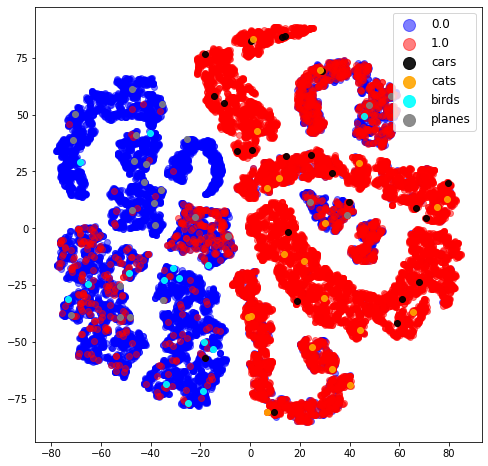

In [ ]:
# Create a two dimensional t-SNE projection of the embeddings.
birds = [0, 13, 40, 54, 74, 80, 82, 18, 29, 37, 59, 76, 95, 98, 99]
planes = [5, 6, 15, 25, 26, 28, 35, 65, 77, 88, 97, 1, 4, 12, 24, 31, 33, 42, 43, 44, 61, 64, 72, 71]
cars = [10, 11, 14, 20, 30, 51, 81, 84, 91, 92, 93, 8, 17, 36, 38, 39, 45, 57, 58, 69, 78, 86, 89]
cats = [7, 9, 27, 46, 47, 49, 55, 67, 2, 3, 21, 22, 23, 34, 53, 60, 62, 70, 83, 90]
print(embeddings_all_both.shape)
print(repr_2d.shape)
print(y_all_both.shape)

def plot_embedding_2d(embeddings, repr_2d, labels = None, title=None, plot_x_val_2d_repr = True):
    if labels is None:
        labels = np.zeros(embeddings.shape[0])
    # Plot those points as a scatter plot and label them based on the pred labels
    colors = ['b', 'r', 'g', 'y', 'c', 'm', 'k', 'w']
    fig, ax = plt.subplots(figsize=(8,8))
    for lab in np.unique(labels):
        indices = labels==lab
        ax.scatter(repr_2d[indices,0], repr_2d[indices,1], c=colors[lab.astype(np.int32)], label = lab ,alpha=0.5)
    if plot_x_val_2d_repr:
        ax.scatter(repr_2d[:, 0][cars], repr_2d[:, 1][cars], c='k', label = 'cars' ,alpha=0.9)
        ax.scatter(repr_2d[:, 0][cats], repr_2d[:, 1][cats], c='orange', label = 'cats' ,alpha=0.9)
        ax.scatter(repr_2d[:, 0][birds], repr_2d[:, 1][birds], c='cyan', label = 'birds' ,alpha=0.9)
        ax.scatter(repr_2d[:, 0][planes], repr_2d[:, 1][planes], c='grey', label = 'planes' ,alpha=0.9)
    ax.legend(fontsize='large', markerscale=2)
    plt.show()
    
plot_embedding_2d(embeddings_all_both[:N], repr_2d = repr_2d[:N] ,labels = y_all_both[:N])

In [ ]:
X_val_both.shape
raise

RuntimeError: No active exception to reraise

In [16]:
# Predict data using resnet
y_pred_val_both = torch.ones((X_val_both.shape[0], 2)) * 66

for k in range(5, 10):
    y_pred_val_both[2000 * k: 2000 * (k+1)] = resnet18(X_val_both[2000 * k: 2000 * (k+1)].to(device))

y_pred_val_both.unique()

OutOfMemoryError: CUDA out of memory. Tried to allocate 126.00 MiB (GPU 0; 7.80 GiB total capacity; 6.36 GiB already allocated; 66.81 MiB free; 6.47 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
y_pred_val_both_label = y_pred_val_both.argmax(axis = 1)
y_pred_val_both_label.shape

y_pred_val_left = y_pred_val_both_label[:20000]
y_pred_val_right = y_pred_val_both_label[20000:]

y_final = torch.ones((20000,))


In [ ]:
y_pred_val_both[:10]

NameError: name 'y_pred_val_both' is not defined

In [ ]:
are_00 = torch.logical_and(y_pred_val_left == 0, y_pred_val_right == 0)
are_11 = torch.logical_and(y_pred_val_left == 1, y_pred_val_right == 1)
are_10 = torch.logical_and(y_pred_val_left == 1, y_pred_val_right == 0)
are_01 = torch.logical_and(y_pred_val_left == 0, y_pred_val_right == 1)
are_unknown = torch.logical_or(are_10, are_01)

y_final[are_00] = 0
y_final[are_11] = 1

In [ ]:

y_final[:100]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

In [ ]:
y_final.unique()

tensor([0., 1.])

In [ ]:
torch.sum(are_00)

tensor(17898)

In [ ]:
torch.sum(are_11)

tensor(0)

In [ ]:
torch.sum(y_pred_val_both_label == 1)

tensor(2102)

In [ ]:
y_pred_val_both_label.shape


torch.Size([40000])

In [ ]:
cluster_classes_val_both.shape

NameError: ignored

In [ ]:
y_final[]

In [ ]:
def AND(a,b):
  return torch.logical_and(a,b)